Updated models

In [1]:
import sys
import os
os.chdir("../") # to go back one file 

# If your notebook is nested somewhere else, you may need to do:
# sys.path.append(os.path.abspath("../src"))

from src.data_utils import get_zinc_dataset
from src.train import train_one_epoch, evaluate, predict
from src.model import get_model
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [2]:
print(os.getcwd())

/Users/abdallahabdelsameia/Desktop/GNN/GNN


# All models

In [3]:
###############################################################################
# 1. LOAD DATA ONCE FOR ALL MODELS
###############################################################################
batch_size = 64
train_loader, val_loader, test_loader = get_zinc_dataset(
    root='../data/ZINC',
    batch_size=batch_size,
    subset=True
)

sample_batch = next(iter(train_loader))
in_channels = sample_batch.x.size(-1)
print(f"Inferred in_channels: {in_channels}")


###############################################################################
# 2. UTILITY FUNCTION TO RUN EXPERIMENT
###############################################################################
def run_experiment(variation_name, model_params, epochs=25, lr=0.001):
    """
    Train and evaluate a model given by model_params, for 'epochs' epochs,
    using MSE loss + Adam at LR=lr. Returns (model, run_info).
    """
    model = get_model(**model_params).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # We'll store results here for logging/analysis
    run_info = {
        'variation': variation_name,
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'epoch_time': [],
        'num_params': sum(p.numel() for p in model.parameters() if p.requires_grad)
    }
    
    # Training Loop
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        
        epoch_time = time.time() - start_time
        
        run_info['epoch'].append(epoch)
        run_info['train_loss'].append(train_loss)
        run_info['val_loss'].append(val_loss)
        run_info['epoch_time'].append(epoch_time)
        
        if epoch % 5 == 0:
            print(f"[{variation_name}] Epoch {epoch}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Time: {epoch_time:.2f}s")

    # Final Test
    test_loss = evaluate(model, test_loader, criterion, device)
    run_info['test_loss'] = test_loss

    # Additional metrics
    preds, targets = predict(model, test_loader, device)
    preds_np, targets_np = preds.numpy(), targets.numpy()
    run_info['test_mae'] = mean_absolute_error(targets_np, preds_np)
    run_info['test_r2']  = r2_score(targets_np, preds_np)

    print(f"[{variation_name}] FINAL TEST | "
          f"MSE: {test_loss:.4f} | MAE: {run_info['test_mae']:.4f} | R^2: {run_info['test_r2']:.4f}")

    return model, run_info




Extracting ../data/ZINC/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 25818.57it/s]

Inferred in_channels: 1



Done!


In [ ]:
###############################################################################
# 3. GCN - 3 Variations
###############################################################################
print("\n=================== GCN Variations ===================")

### Variation 1: Basic
gcn_v1_params = {
    'model_name': 'gcn',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.0,
    'activation': 'relu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}
gcn_v1_model, gcn_v1_info = run_experiment(
    variation_name="GCN_V1_Basic",
    model_params=gcn_v1_params,
    epochs=3000,
    lr=0.001
)

### Variation 2: Dropout + LeakyReLU
gcn_v2_params = {
    'model_name': 'gcn',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}
gcn_v2_model, gcn_v2_info = run_experiment(
    variation_name="GCN_V2_Dropout_LeakyReLU",
    model_params=gcn_v2_params,
    epochs=3000,
    lr=0.001
)

### Variation 3: Full-feature (Attention, Residual, BN)
gcn_v3_params = {
    'model_name': 'gcn',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'attention',
    'residual': True,
    'batch_norm': True
}
gcn_v3_model, gcn_v3_info = run_experiment(
    variation_name="GCN_V3_Attn_Residual_BN",
    model_params=gcn_v3_params,
    epochs=3000,
    lr=0.001
)


###############################################################################
# 4. GIN - 3 Variations
###############################################################################
print("\n=================== GIN Variations ===================")

### Variation 1: Basic
gin_v1_params = {
    'model_name': 'gin',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.0,
    'activation': 'relu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}
gin_v1_model, gin_v1_info = run_experiment(
    variation_name="GIN_V1_Basic",
    model_params=gin_v1_params,
    epochs=3000,
    lr=0.001
)

### Variation 2: Dropout + LeakyReLU
gin_v2_params = {
    'model_name': 'gin',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}
gin_v2_model, gin_v2_info = run_experiment(
    variation_name="GIN_V2_Dropout_LeakyReLU",
    model_params=gin_v2_params,
    epochs=3000,
    lr=0.001
)

### Variation 3: Full-feature
gin_v3_params = {
    'model_name': 'gin',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'attention',
    'residual': True,
    'batch_norm': True
}
gin_v3_model, gin_v3_info = run_experiment(
    variation_name="GIN_V3_Attn_Residual_BN",
    model_params=gin_v3_params,
    epochs=3000,
    lr=0.001
)


###############################################################################
# 5. GAT - 3 Variations
###############################################################################
print("\n=================== GAT Variations ===================")

### Variation 1: Basic
gat_v1_params = {
    'model_name': 'gat',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'heads': 4,
    'dropout': 0.0,
    'activation': 'relu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}
gat_v1_model, gat_v1_info = run_experiment(
    variation_name="GAT_V1_Basic",
    model_params=gat_v1_params,
    epochs=3000,
    lr=0.001
)

### Variation 2: Dropout + LeakyReLU + More Heads
gat_v2_params = {
    'model_name': 'gat',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'heads': 8,            # maybe try more heads
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}
gat_v2_model, gat_v2_info = run_experiment(
    variation_name="GAT_V2_Dropout_LeakyReLU",
    model_params=gat_v2_params,
    epochs=3000,
    lr=0.001
)

### Variation 3: Full-feature
gat_v3_params = {
    'model_name': 'gat',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'heads': 8,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'attention',
    'residual': True,
    'batch_norm': True
}
gat_v3_model, gat_v3_info = run_experiment(
    variation_name="GAT_V3_Attn_Residual_BN",
    model_params=gat_v3_params,
    epochs=3000,
    lr=0.001
)


###############################################################################
# 6. SAGE - 3 Variations
###############################################################################
print("\n=================== SAGE Variations ===================")

### Variation 1: Basic
sage_v1_params = {
    'model_name': 'sage',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.0,
    'activation': 'relu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}
sage_v1_model, sage_v1_info = run_experiment(
    variation_name="SAGE_V1_Basic",
    model_params=sage_v1_params,
    epochs=3000,
    lr=0.001
)

### Variation 2: Dropout + LeakyReLU
sage_v2_params = {
    'model_name': 'sage',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}
sage_v2_model, sage_v2_info = run_experiment(
    variation_name="SAGE_V2_Dropout_LeakyReLU",
    model_params=sage_v2_params,
    epochs=3000,
    lr=0.001
)

### Variation 3: Full-feature
sage_v3_params = {
    'model_name': 'sage',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'attention',
    'residual': True,
    'batch_norm': True
}
sage_v3_model, sage_v3_info = run_experiment(
    variation_name="SAGE_V3_Attn_Residual_BN",
    model_params=sage_v3_params,
    epochs=3000,
    lr=0.001
)

print("\n=== All runs complete! Check the logs above for final metrics. ===")

In [80]:
# import torch
# import os

# save_dir = "../data/experiments_"
# os.makedirs(save_dir, exist_ok=True)

# # GCN
# torch.save(gcn_v1_model.state_dict(), os.path.join(save_dir, "gcn_v1_model.pt"))
# torch.save(gcn_v1_info,  os.path.join(save_dir, "gcn_v1_info.pt"))

# torch.save(gcn_v2_model.state_dict(), os.path.join(save_dir, "gcn_v2_model.pt"))
# torch.save(gcn_v2_info,  os.path.join(save_dir, "gcn_v2_info.pt"))

# torch.save(gcn_v3_model.state_dict(), os.path.join(save_dir, "gcn_v3_model.pt"))
# torch.save(gcn_v3_info,  os.path.join(save_dir, "gcn_v3_info.pt"))

# # GIN
# torch.save(gin_v1_model.state_dict(), os.path.join(save_dir, "gin_v1_model.pt"))
# torch.save(gin_v1_info,  os.path.join(save_dir, "gin_v1_info.pt"))

# torch.save(gin_v2_model.state_dict(), os.path.join(save_dir, "gin_v2_model.pt"))
# torch.save(gin_v2_info,  os.path.join(save_dir, "gin_v2_info.pt"))

# torch.save(gin_v3_model.state_dict(), os.path.join(save_dir, "gin_v3_model.pt"))
# torch.save(gin_v3_info,  os.path.join(save_dir, "gin_v3_info.pt"))

# # GAT
# torch.save(gat_v1_model.state_dict(), os.path.join(save_dir, "gat_v1_model.pt"))
# torch.save(gat_v1_info,  os.path.join(save_dir, "gat_v1_info.pt"))

# torch.save(gat_v2_model.state_dict(), os.path.join(save_dir, "gat_v2_model.pt"))
# torch.save(gat_v2_info,  os.path.join(save_dir, "gat_v2_info.pt"))

# torch.save(gat_v3_model.state_dict(), os.path.join(save_dir, "gat_v3_model.pt"))
# torch.save(gat_v3_info,  os.path.join(save_dir, "gat_v3_info.pt"))

# # GraphSAGE
# torch.save(sage_v1_model.state_dict(), os.path.join(save_dir, "sage_v1_model.pt"))
# torch.save(sage_v1_info,  os.path.join(save_dir, "sage_v1_info.pt"))

# torch.save(sage_v2_model.state_dict(), os.path.join(save_dir, "sage_v2_model.pt"))
# torch.save(sage_v2_info,  os.path.join(save_dir, "sage_v2_info.pt"))

# torch.save(sage_v3_model.state_dict(), os.path.join(save_dir, "sage_v3_model.pt"))
# torch.save(sage_v3_info,  os.path.join(save_dir, "sage_v3_info.pt"))


### Reloading

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

### Variation 1: Basic
gcn_v1_params = {
    'model_name': 'gcn',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.0,
    'activation': 'relu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}

gcn_v2_params = {
    'model_name': 'gcn',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}

gcn_v3_params = {
    'model_name': 'gcn',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'attention',
    'residual': True,
    'batch_norm': True
}

gin_v1_params = {
    'model_name': 'gin',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.0,
    'activation': 'relu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}

gin_v2_params = {
    'model_name': 'gin',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}

gin_v3_params = {
    'model_name': 'gin',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'attention',
    'residual': True,
    'batch_norm': True
}

gat_v1_params = {
    'model_name': 'gat',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'heads': 4,
    'dropout': 0.0,
    'activation': 'relu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}

gat_v2_params = {
    'model_name': 'gat',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'heads': 8,            # maybe try more heads
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}

gat_v3_params = {
    'model_name': 'gat',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'heads': 8,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'attention',
    'residual': True,
    'batch_norm': True
}

sage_v1_params = {
    'model_name': 'sage',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.0,
    'activation': 'relu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}

sage_v2_params = {
    'model_name': 'sage',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}

sage_v3_params = {
    'model_name': 'sage',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'attention',
    'residual': True,
    'batch_norm': True
}

#------------------- GINE -------------------
gine_v1_params = {
    'model_name': 'gine',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.0,
    'activation': 'relu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}

gine_v2_params = {
    'model_name': 'gine',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'mean',
    'residual': False,
    'batch_norm': False
}

gine_v3_params = {
    'model_name': 'gine',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'attention',
    'residual': True,
    'batch_norm': True
}


In [5]:
print(os.getcwd())

/Users/abdallahabdelsameia/Desktop/GNN/GNN


In [6]:
save_dir = "data/experiments"

###############################################################################
# GCN V1
###############################################################################
# Step 2: Re-initialize the model
gcn_v1_reloaded = get_model(**gcn_v1_params).to(device)

# Step 3: Load the saved state dictionary
gcn_v1_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gcn_v1_model.pt"), map_location=device))
gcn_v1_reloaded.eval()

# Step 4: Load the info dictionary
gcn_v1_info_reloaded = torch.load(os.path.join(save_dir, "gcn_v1_info.pt"))

print("GCN_V1 model and info loaded!")
print("Saved final test loss:", gcn_v1_info_reloaded['test_loss'])


###############################################################################
# GCN V2
###############################################################################
gcn_v2_reloaded = get_model(**gcn_v2_params).to(device)
gcn_v2_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gcn_v2_model.pt"), map_location=device))
gcn_v2_reloaded.eval()

gcn_v2_info_reloaded = torch.load(os.path.join(save_dir, "gcn_v2_info.pt"))
print("GCN_V2 model and info loaded!")
print("Saved final test loss:", gcn_v2_info_reloaded['test_loss'])


###############################################################################
# GCN V3
###############################################################################
gcn_v3_reloaded = get_model(**gcn_v3_params).to(device)
gcn_v3_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gcn_v3_model.pt"), map_location=device))
gcn_v3_reloaded.eval()

gcn_v3_info_reloaded = torch.load(os.path.join(save_dir, "gcn_v3_info.pt"))
print("GCN_V3 model and info loaded!")
print("Saved final test loss:", gcn_v3_info_reloaded['test_loss'])


###############################################################################
# GIN V1
###############################################################################
gin_v1_reloaded = get_model(**gin_v1_params).to(device)
gin_v1_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gin_v1_model.pt"), map_location=device))
gin_v1_reloaded.eval()

gin_v1_info_reloaded = torch.load(os.path.join(save_dir, "gin_v1_info.pt"))
print("GIN_V1 model and info loaded!")
print("Saved final test loss:", gin_v1_info_reloaded['test_loss'])


###############################################################################
# GIN V2
###############################################################################
gin_v2_reloaded = get_model(**gin_v2_params).to(device)
gin_v2_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gin_v2_model.pt"), map_location=device))
gin_v2_reloaded.eval()

gin_v2_info_reloaded = torch.load(os.path.join(save_dir, "gin_v2_info.pt"))
print("GIN_V2 model and info loaded!")
print("Saved final test loss:", gin_v2_info_reloaded['test_loss'])


###############################################################################
# GIN V3
###############################################################################
gin_v3_reloaded = get_model(**gin_v3_params).to(device)
gin_v3_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gin_v3_model.pt"), map_location=device))
gin_v3_reloaded.eval()

gin_v3_info_reloaded = torch.load(os.path.join(save_dir, "gin_v3_info.pt"))
print("GIN_V3 model and info loaded!")
print("Saved final test loss:", gin_v3_info_reloaded['test_loss'])


###############################################################################
# GAT V1
###############################################################################
gat_v1_reloaded = get_model(**gat_v1_params).to(device)
gat_v1_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gat_v1_model.pt"), map_location=device))
gat_v1_reloaded.eval()

gat_v1_info_reloaded = torch.load(os.path.join(save_dir, "gat_v1_info.pt"))
print("GAT_V1 model and info loaded!")
print("Saved final test loss:", gat_v1_info_reloaded['test_loss'])


###############################################################################
# GAT V2
###############################################################################
gat_v2_reloaded = get_model(**gat_v2_params).to(device)
gat_v2_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gat_v2_model.pt"), map_location=device))
gat_v2_reloaded.eval()

gat_v2_info_reloaded = torch.load(os.path.join(save_dir, "gat_v2_info.pt"))
print("GAT_V2 model and info loaded!")
print("Saved final test loss:", gat_v2_info_reloaded['test_loss'])


###############################################################################
# GAT V3
###############################################################################
gat_v3_reloaded = get_model(**gat_v3_params).to(device)
gat_v3_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gat_v3_model.pt"), map_location=device))
gat_v3_reloaded.eval()

gat_v3_info_reloaded = torch.load(os.path.join(save_dir, "gat_v3_info.pt"))
print("GAT_V3 model and info loaded!")
print("Saved final test loss:", gat_v3_info_reloaded['test_loss'])


###############################################################################
# SAGE V1
###############################################################################
sage_v1_reloaded = get_model(**sage_v1_params).to(device)
sage_v1_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "sage_v1_model.pt"), map_location=device))
sage_v1_reloaded.eval()

sage_v1_info_reloaded = torch.load(os.path.join(save_dir, "sage_v1_info.pt"))
print("SAGE_V1 model and info loaded!")
print("Saved final test loss:", sage_v1_info_reloaded['test_loss'])


###############################################################################
# SAGE V2
###############################################################################
sage_v2_reloaded = get_model(**sage_v2_params).to(device)
sage_v2_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "sage_v2_model.pt"), map_location=device))
sage_v2_reloaded.eval()

sage_v2_info_reloaded = torch.load(os.path.join(save_dir, "sage_v2_info.pt"))
print("SAGE_V2 model and info loaded!")
print("Saved final test loss:", sage_v2_info_reloaded['test_loss'])


###############################################################################
# SAGE V3
###############################################################################
sage_v3_reloaded = get_model(**sage_v3_params).to(device)
sage_v3_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "sage_v3_model.pt"), map_location=device))
sage_v3_reloaded.eval()

sage_v3_info_reloaded = torch.load(os.path.join(save_dir, "sage_v3_info.pt"))
print("SAGE_V3 model and info loaded!")
print("Saved final test loss:", sage_v3_info_reloaded['test_loss'])


###############################################################################
# GINE V1
###############################################################################
gine_v1_reloaded = get_model(**gine_v1_params).to(device)
gine_v1_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gine_v1_model.pt"), map_location=device))
gine_v1_reloaded.eval()

gine_v1_info_reloaded = torch.load(os.path.join(save_dir, "gine_v1_info.pt"))
print("GINE_V1 model and info loaded!")
print("Saved final test loss:", gine_v1_info_reloaded['test_loss'])


###############################################################################
# GINE V2
###############################################################################
gine_v2_reloaded = get_model(**gine_v2_params).to(device)
gine_v2_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gine_v2_model.pt"), map_location=device))
gine_v2_reloaded.eval()

gine_v2_info_reloaded = torch.load(os.path.join(save_dir, "gine_v2_info.pt"))
print("GINE_V2 model and info loaded!")
print("Saved final test loss:", gine_v2_info_reloaded['test_loss'])


###############################################################################
# GINE V3
###############################################################################
gine_v3_reloaded = get_model(**gine_v3_params).to(device)
gine_v3_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "gine_v3_model.pt"), map_location=device))
gine_v3_reloaded.eval()

gine_v3_info_reloaded = torch.load(os.path.join(save_dir, "gine_v3_info.pt"))
print("GINE_V3 model and info loaded!")
print("Saved final test loss:", gine_v3_info_reloaded['test_loss'])



GCN_V1 model and info loaded!
Saved final test loss: 1.9782163028717041
GCN_V2 model and info loaded!
Saved final test loss: 2.2265570373535155
GCN_V3 model and info loaded!
Saved final test loss: 1.7909226036071777
GIN_V1 model and info loaded!
Saved final test loss: 1.3640117816925048
GIN_V2 model and info loaded!
Saved final test loss: 1.5851879434585572
GIN_V3 model and info loaded!
Saved final test loss: 1.4070508365631103
GAT_V1 model and info loaded!
Saved final test loss: 1.3102750034332276
GAT_V2 model and info loaded!
Saved final test loss: 1.3835705480575562
GAT_V3 model and info loaded!
Saved final test loss: 1.3173108053207399
SAGE_V1 model and info loaded!
Saved final test loss: 1.2819030427932738
SAGE_V2 model and info loaded!
Saved final test loss: 1.4416164207458495
SAGE_V3 model and info loaded!
Saved final test loss: 1.3881172361373901
GINE_V1 model and info loaded!
Saved final test loss: 1.035608479976654
GINE_V2 model and info loaded!
Saved final test loss: 1.08256

/var/folders/p5/dn4spxsx2897rzdgf07vym2c0000gn/T/ipykernel_62969/3833454465.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_v1_reloaded.load_state_dict(torch.load(o

In [13]:
all_results = {
    "GCN_V1_Basic": gcn_v1_info_reloaded,
    "GCN_V2_Dropout_LeakyReLU": gcn_v2_info_reloaded,
    "GCN_V3_Attn_Residual_BN": gcn_v3_info_reloaded,

    "GIN_V1_Basic": gin_v1_info_reloaded,
    "GIN_V2_Dropout_LeakyReLU": gin_v2_info_reloaded,
    "GIN_V3_Attn_Residual_BN": gin_v3_info_reloaded,

    "GAT_V1_Basic": gat_v1_info_reloaded,
    "GAT_V2_Dropout_LeakyReLU": gat_v2_info_reloaded,
    "GAT_V3_Attn_Residual_BN": gat_v3_info_reloaded,

    "SAGE_V1_Basic": sage_v1_info_reloaded,
    "SAGE_V2_Dropout_LeakyReLU": sage_v2_info_reloaded,
    "SAGE_V3_Attn_Residual_BN": sage_v3_info_reloaded,

    "GINE_V1_Basic": gine_v1_info_reloaded,
    "GINE_V2_Dropout_LeakyReLU": gine_v2_info_reloaded,
    "GINE_V3_Attn_Residual_BN": gine_v3_info_reloaded,
}

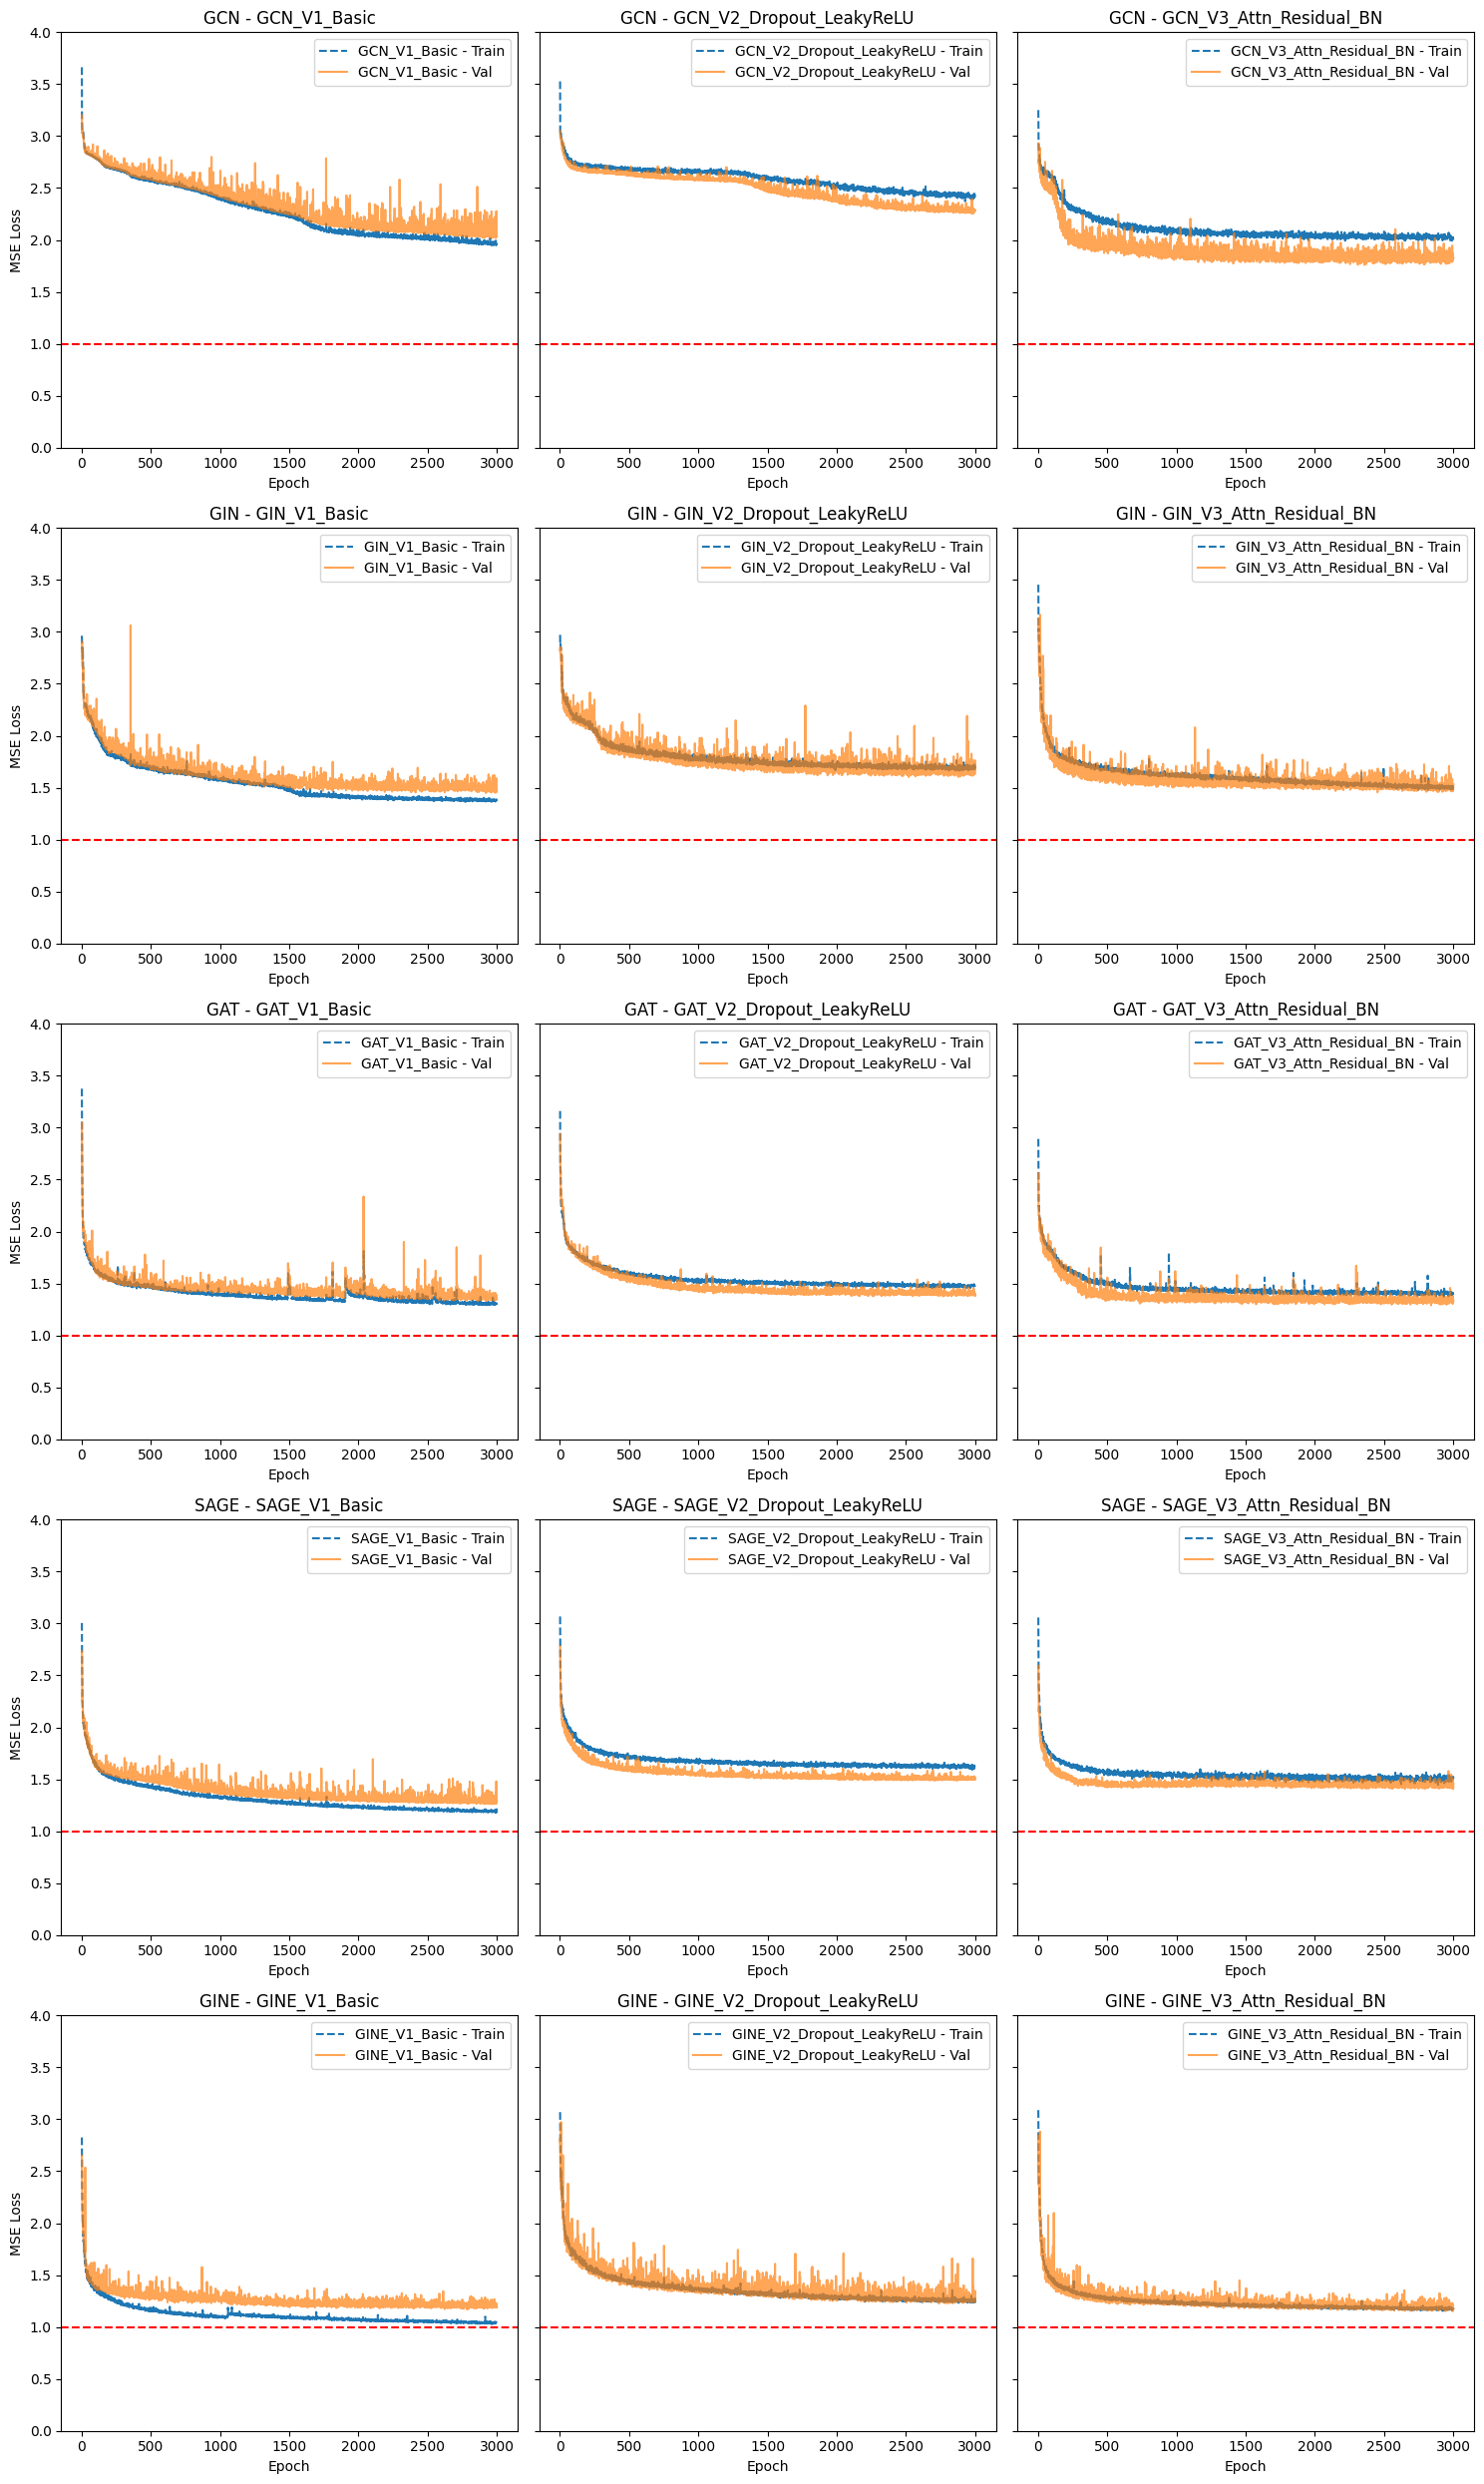

In [18]:
# --------------------------------------------------------------------------------
# Cell: Comparative Plots (Loss Curves) in a 4x3 grid
# --------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# Group variations by model type:
model_variations_dict = {
    "GCN": [
        "GCN_V1_Basic",
        "GCN_V2_Dropout_LeakyReLU",
        "GCN_V3_Attn_Residual_BN"
    ],
    "GIN": [
        "GIN_V1_Basic",
        "GIN_V2_Dropout_LeakyReLU",
        "GIN_V3_Attn_Residual_BN"
    ],
    "GAT": [
        "GAT_V1_Basic",
        "GAT_V2_Dropout_LeakyReLU",
        "GAT_V3_Attn_Residual_BN"
    ],
    "SAGE": [
        "SAGE_V1_Basic",
        "SAGE_V2_Dropout_LeakyReLU",
        "SAGE_V3_Attn_Residual_BN"
    ],
    "GINE": [
        "GINE_V1_Basic",
        "GINE_V2_Dropout_LeakyReLU",
        "GINE_V3_Attn_Residual_BN"
    ],
}

# Create a 5 (rows) x 3 (columns) figure, sharing the y-axis
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 25), sharey=True)

# Ensure we have a fixed order for the rows
model_types_in_order = ["GCN", "GIN", "GAT", "SAGE", "GINE"]

for row_idx, model_type in enumerate(model_types_in_order):
    # Retrieve the 3 variations for this model type
    variations_list = model_variations_dict[model_type]
    
    for col_idx, var_name in enumerate(variations_list):
        ax = axes[row_idx, col_idx]

        # If this variation wasn't actually run or doesn't exist in all_results, skip it
        if var_name not in all_results:
            ax.set_visible(False)  # Hide the empty subplot
            continue

        # Extract the info from all_results
        info_dict = all_results[var_name]
        epochs = info_dict['epoch']
        train_loss = info_dict['train_loss']
        val_loss = info_dict['val_loss']
        variation_label = info_dict['variation']  # e.g. "GCN_V1_Basic"

        # Plot train loss (dashed)
        ax.plot(epochs, train_loss, '--', label=f"{variation_label} - Train")
        # Plot val loss (solid)
        ax.plot(epochs, val_loss, label=f"{variation_label} - Val", alpha = 0.7)

        # Draw horizontal dashed red line at y = 1
        ax.axhline(y=1, color='red', linestyle='--')

        # Set titles, labels, etc.
        ax.set_title(f"{model_type} - {variation_label}")
        ax.set_xlabel("Epoch")
        # Only set the y-label on the leftmost column
        if col_idx == 0:
            ax.set_ylabel("MSE Loss")
        
        ax.set_ylim(0, 4)  # lock y-axis from 0 to 4
        ax.legend()

plt.tight_layout()
plt.savefig("../images/comparative_loss_curves.pdf", format="pdf", bbox_inches="tight")
plt.show()


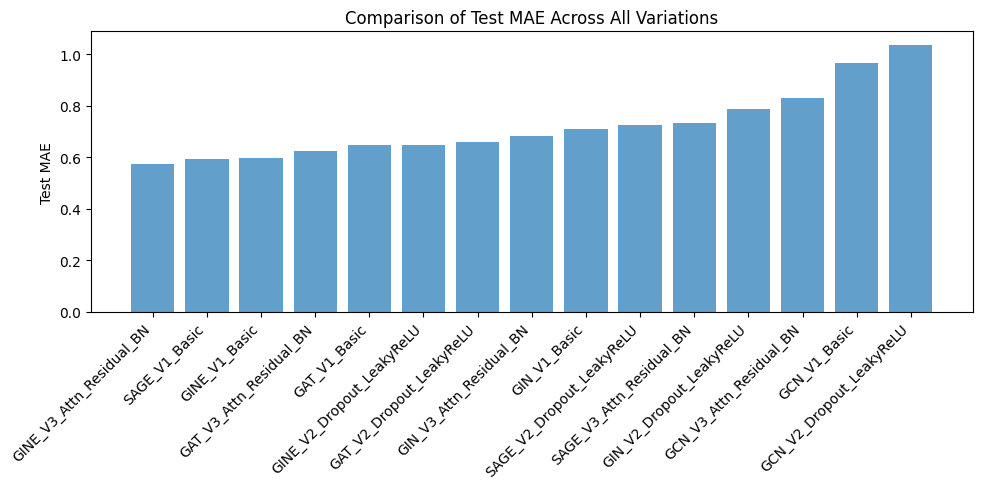

In [22]:
# --------------------------------------------------------------------------------
# Cell: Comparative Plots (Test MAE)
# --------------------------------------------------------------------------------
import numpy as np

variations = list(all_results.keys())
mae_values = [all_results[v]["test_mae"] for v in variations]

# Sort the MAE values and corresponding variations
sorted_indices = np.argsort(mae_values)
sorted_mae_values = np.array(mae_values)[sorted_indices]
sorted_variations = np.array(variations)[sorted_indices]

plt.figure(figsize=(10, 5))
x_pos = np.arange(len(sorted_variations))
plt.bar(x_pos, sorted_mae_values, align='center', alpha=0.7)
plt.xticks(x_pos, sorted_variations, rotation=45, ha='right')
plt.ylabel("Test MAE")
plt.title("Comparison of Test MAE Across All Variations")
plt.tight_layout()
plt.savefig("../images/comparative_MAE.pdf", format="pdf", bbox_inches="tight")
plt.show()

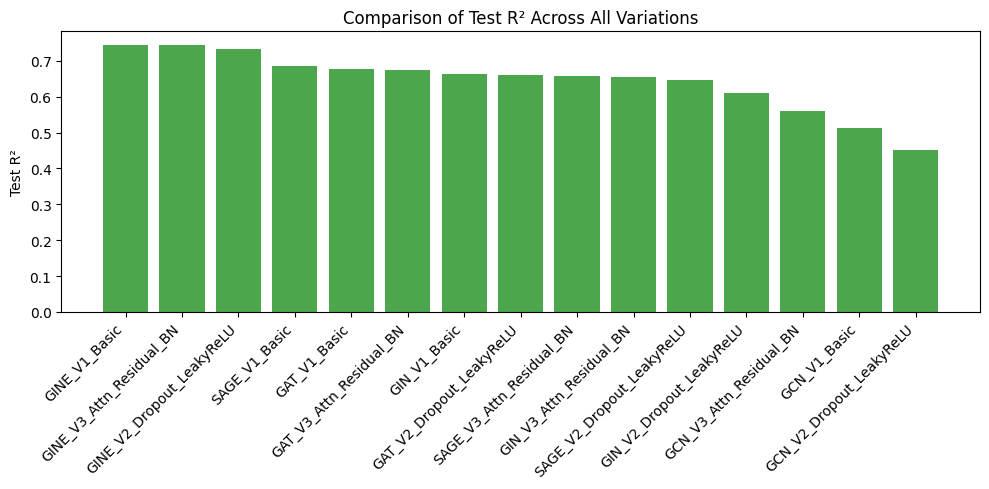

In [24]:
# --------------------------------------------------------------------------------
# Cell: Comparative Plots (Test R^2)
# --------------------------------------------------------------------------------
r2_values = [all_results[v]["test_r2"] for v in variations]

# Sort the R² values and corresponding variations in descending order
sorted_indices = np.argsort(r2_values)[::-1]
sorted_r2_values = np.array(r2_values)[sorted_indices]
sorted_variations = np.array(variations)[sorted_indices]

plt.figure(figsize=(10, 5))
x_pos = np.arange(len(sorted_variations))
plt.bar(x_pos, sorted_r2_values, align='center', alpha=0.7, color='green')
plt.xticks(x_pos, sorted_variations, rotation=45, ha='right')
plt.ylabel("Test R²")
plt.title("Comparison of Test R² Across All Variations")
plt.tight_layout()
plt.savefig("../images/comparative_Rsquared.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [26]:
# --------------------------------------------------------------------------------
# Cell: Generate predictions for each variation & store in all_results
# --------------------------------------------------------------------------------

# Suppose you saved the actual trained model references in a dictionary as well:
trained_models = {
    # GCN
    "GCN_V1_Basic": gcn_v1_reloaded,
    "GCN_V2_Dropout_LeakyReLU": gcn_v2_reloaded,
    "GCN_V3_Attn_Residual_BN": gcn_v3_reloaded,

    # GIN
    "GIN_V1_Basic": gin_v1_reloaded,
    "GIN_V2_Dropout_LeakyReLU": gin_v2_reloaded,
    "GIN_V3_Attn_Residual_BN": gin_v3_reloaded,

    # GAT
    "GAT_V1_Basic": gat_v1_reloaded,
    "GAT_V2_Dropout_LeakyReLU": gat_v2_reloaded,
    "GAT_V3_Attn_Residual_BN": gat_v3_reloaded,

    # GraphSAGE
    "SAGE_V1_Basic": sage_v1_reloaded,
    "SAGE_V2_Dropout_LeakyReLU": sage_v2_reloaded,
    "SAGE_V3_Attn_Residual_BN": sage_v3_reloaded,

    # GINE
    "GINE_V1_Basic": gine_v1_reloaded,
    "GINE_V2_Dropout_LeakyReLU": gine_v2_reloaded,
    "GINE_V3_Attn_Residual_BN": gine_v3_reloaded
}


for var_name, model in trained_models.items():
    if var_name not in all_results:
        continue
    print(f"Generating predictions for {var_name} ...")
    model.eval()
    
    predictions = []
    targets = []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x.float(), data.edge_index, data.batch, data.edge_attr.float()).squeeze(-1)
            predictions.append(out.cpu())
            targets.append(data.y.cpu())

    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)

    # Convert to numpy for plotting
    preds_np = predictions.numpy()
    targets_np = targets.numpy()

    # Store in the run_info dictionary
    all_results[var_name]["preds_np"] = preds_np
    all_results[var_name]["targets_np"] = targets_np


Generating predictions for GCN_V1_Basic ...
Generating predictions for GCN_V2_Dropout_LeakyReLU ...
Generating predictions for GCN_V3_Attn_Residual_BN ...
Generating predictions for GIN_V1_Basic ...
Generating predictions for GIN_V2_Dropout_LeakyReLU ...
Generating predictions for GIN_V3_Attn_Residual_BN ...
Generating predictions for GAT_V1_Basic ...
Generating predictions for GAT_V2_Dropout_LeakyReLU ...
Generating predictions for GAT_V3_Attn_Residual_BN ...
Generating predictions for SAGE_V1_Basic ...
Generating predictions for SAGE_V2_Dropout_LeakyReLU ...
Generating predictions for SAGE_V3_Attn_Residual_BN ...
Generating predictions for GINE_V1_Basic ...
Generating predictions for GINE_V2_Dropout_LeakyReLU ...
Generating predictions for GINE_V3_Attn_Residual_BN ...


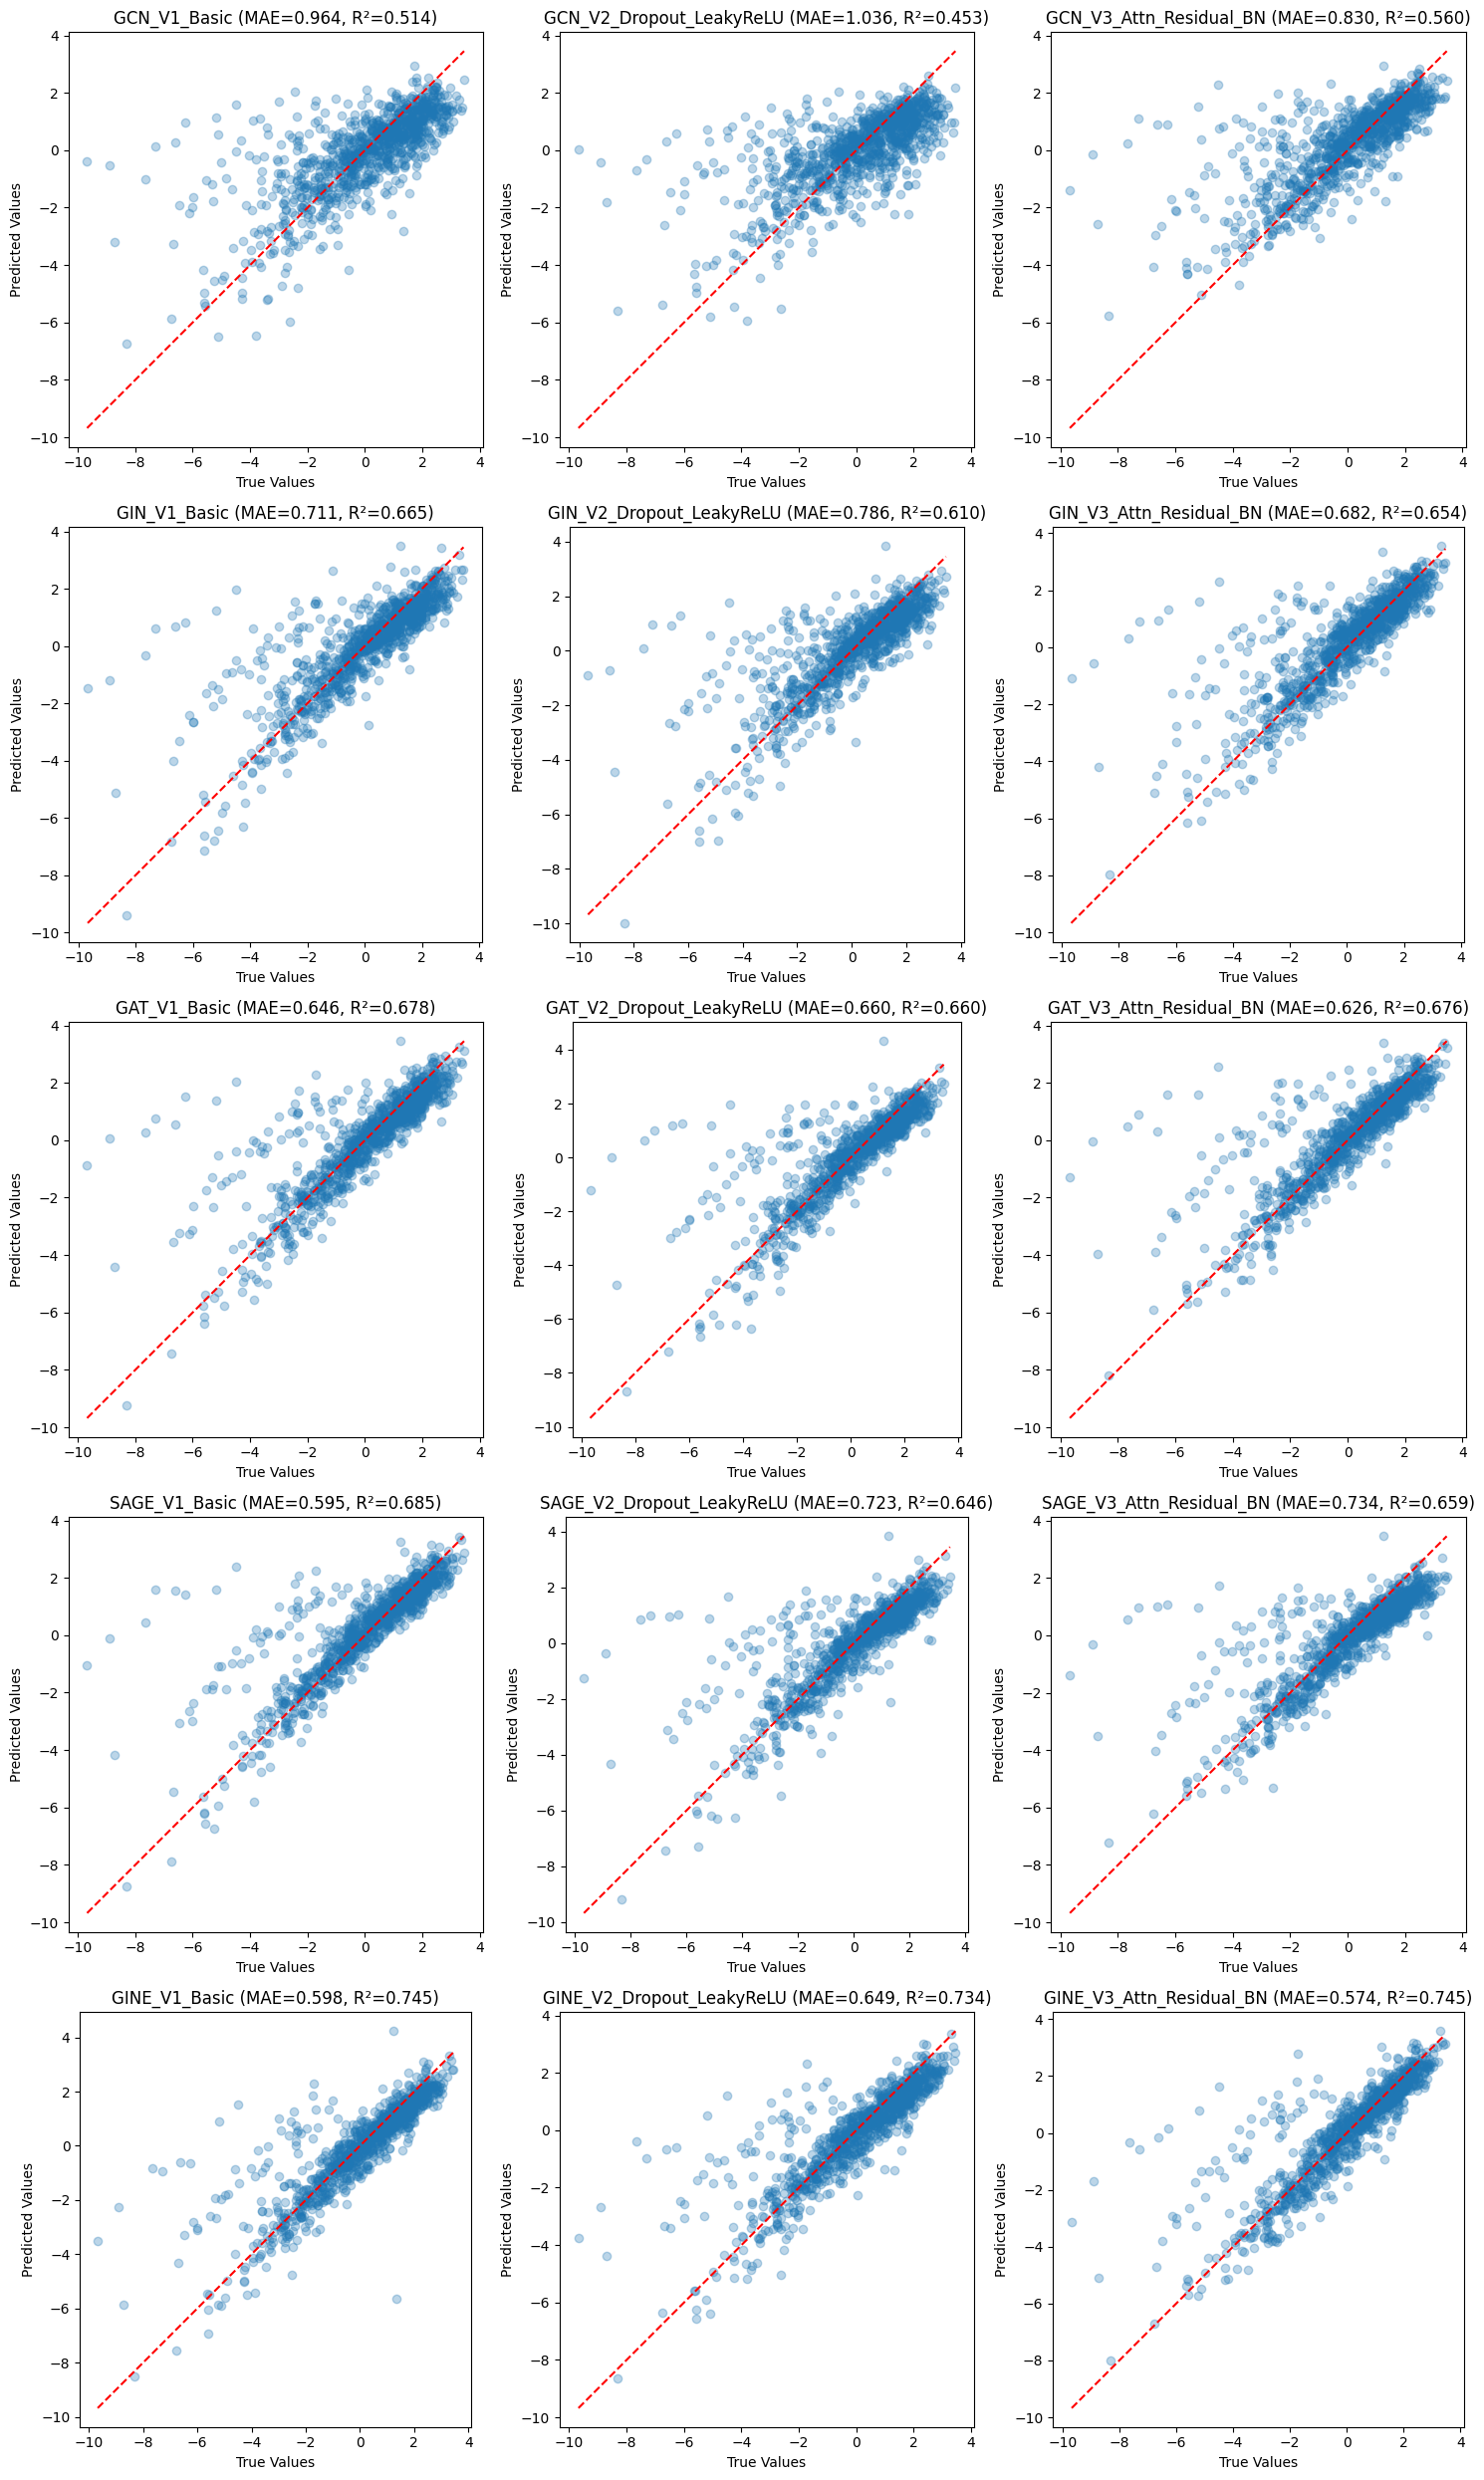

In [27]:
# --------------------------------------------------------------------------------
# Cell: Compare Predicted vs. Actual (Scatter) for Each Variation
# --------------------------------------------------------------------------------
n_cols = 3
n_rows = int(np.ceil(len(all_results)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for idx, (name, info_dict) in enumerate(all_results.items()):
    preds = info_dict.get('preds_np', None)
    targets = info_dict.get('targets_np', None)
    
    # If you didn't store preds_np/targets_np, you can replicate how you stored them in run_experiment
    # but let's assume they're in info_dict or we skip the ones that aren't
    mae = info_dict.get('test_mae', None)
    r2 = info_dict.get('test_r2', None)

    ax = axes[idx]
    if preds is not None and targets is not None:
        ax.scatter(targets, preds, alpha=0.3)
        # Plot diagonal
        min_val, max_val = targets.min(), targets.max()
        ax.plot([min_val, max_val], [min_val, max_val], 'r--')
        ax.set_xlabel("True Values")
        ax.set_ylabel("Predicted Values")
        ax.set_title(f"{name} (MAE={mae:.3f}, R²={r2:.3f})")
    else:
        ax.text(0.5, 0.5, f"No preds in {name}", ha='center', va='center')
    ax.set_aspect('equal', 'box')
 
for extra_ax in axes[len(all_results):]:
    extra_ax.axis('off')

plt.tight_layout()
plt.savefig("../images/comparative_y_predictions.pdf", format="pdf", bbox_inches="tight")
plt.show()


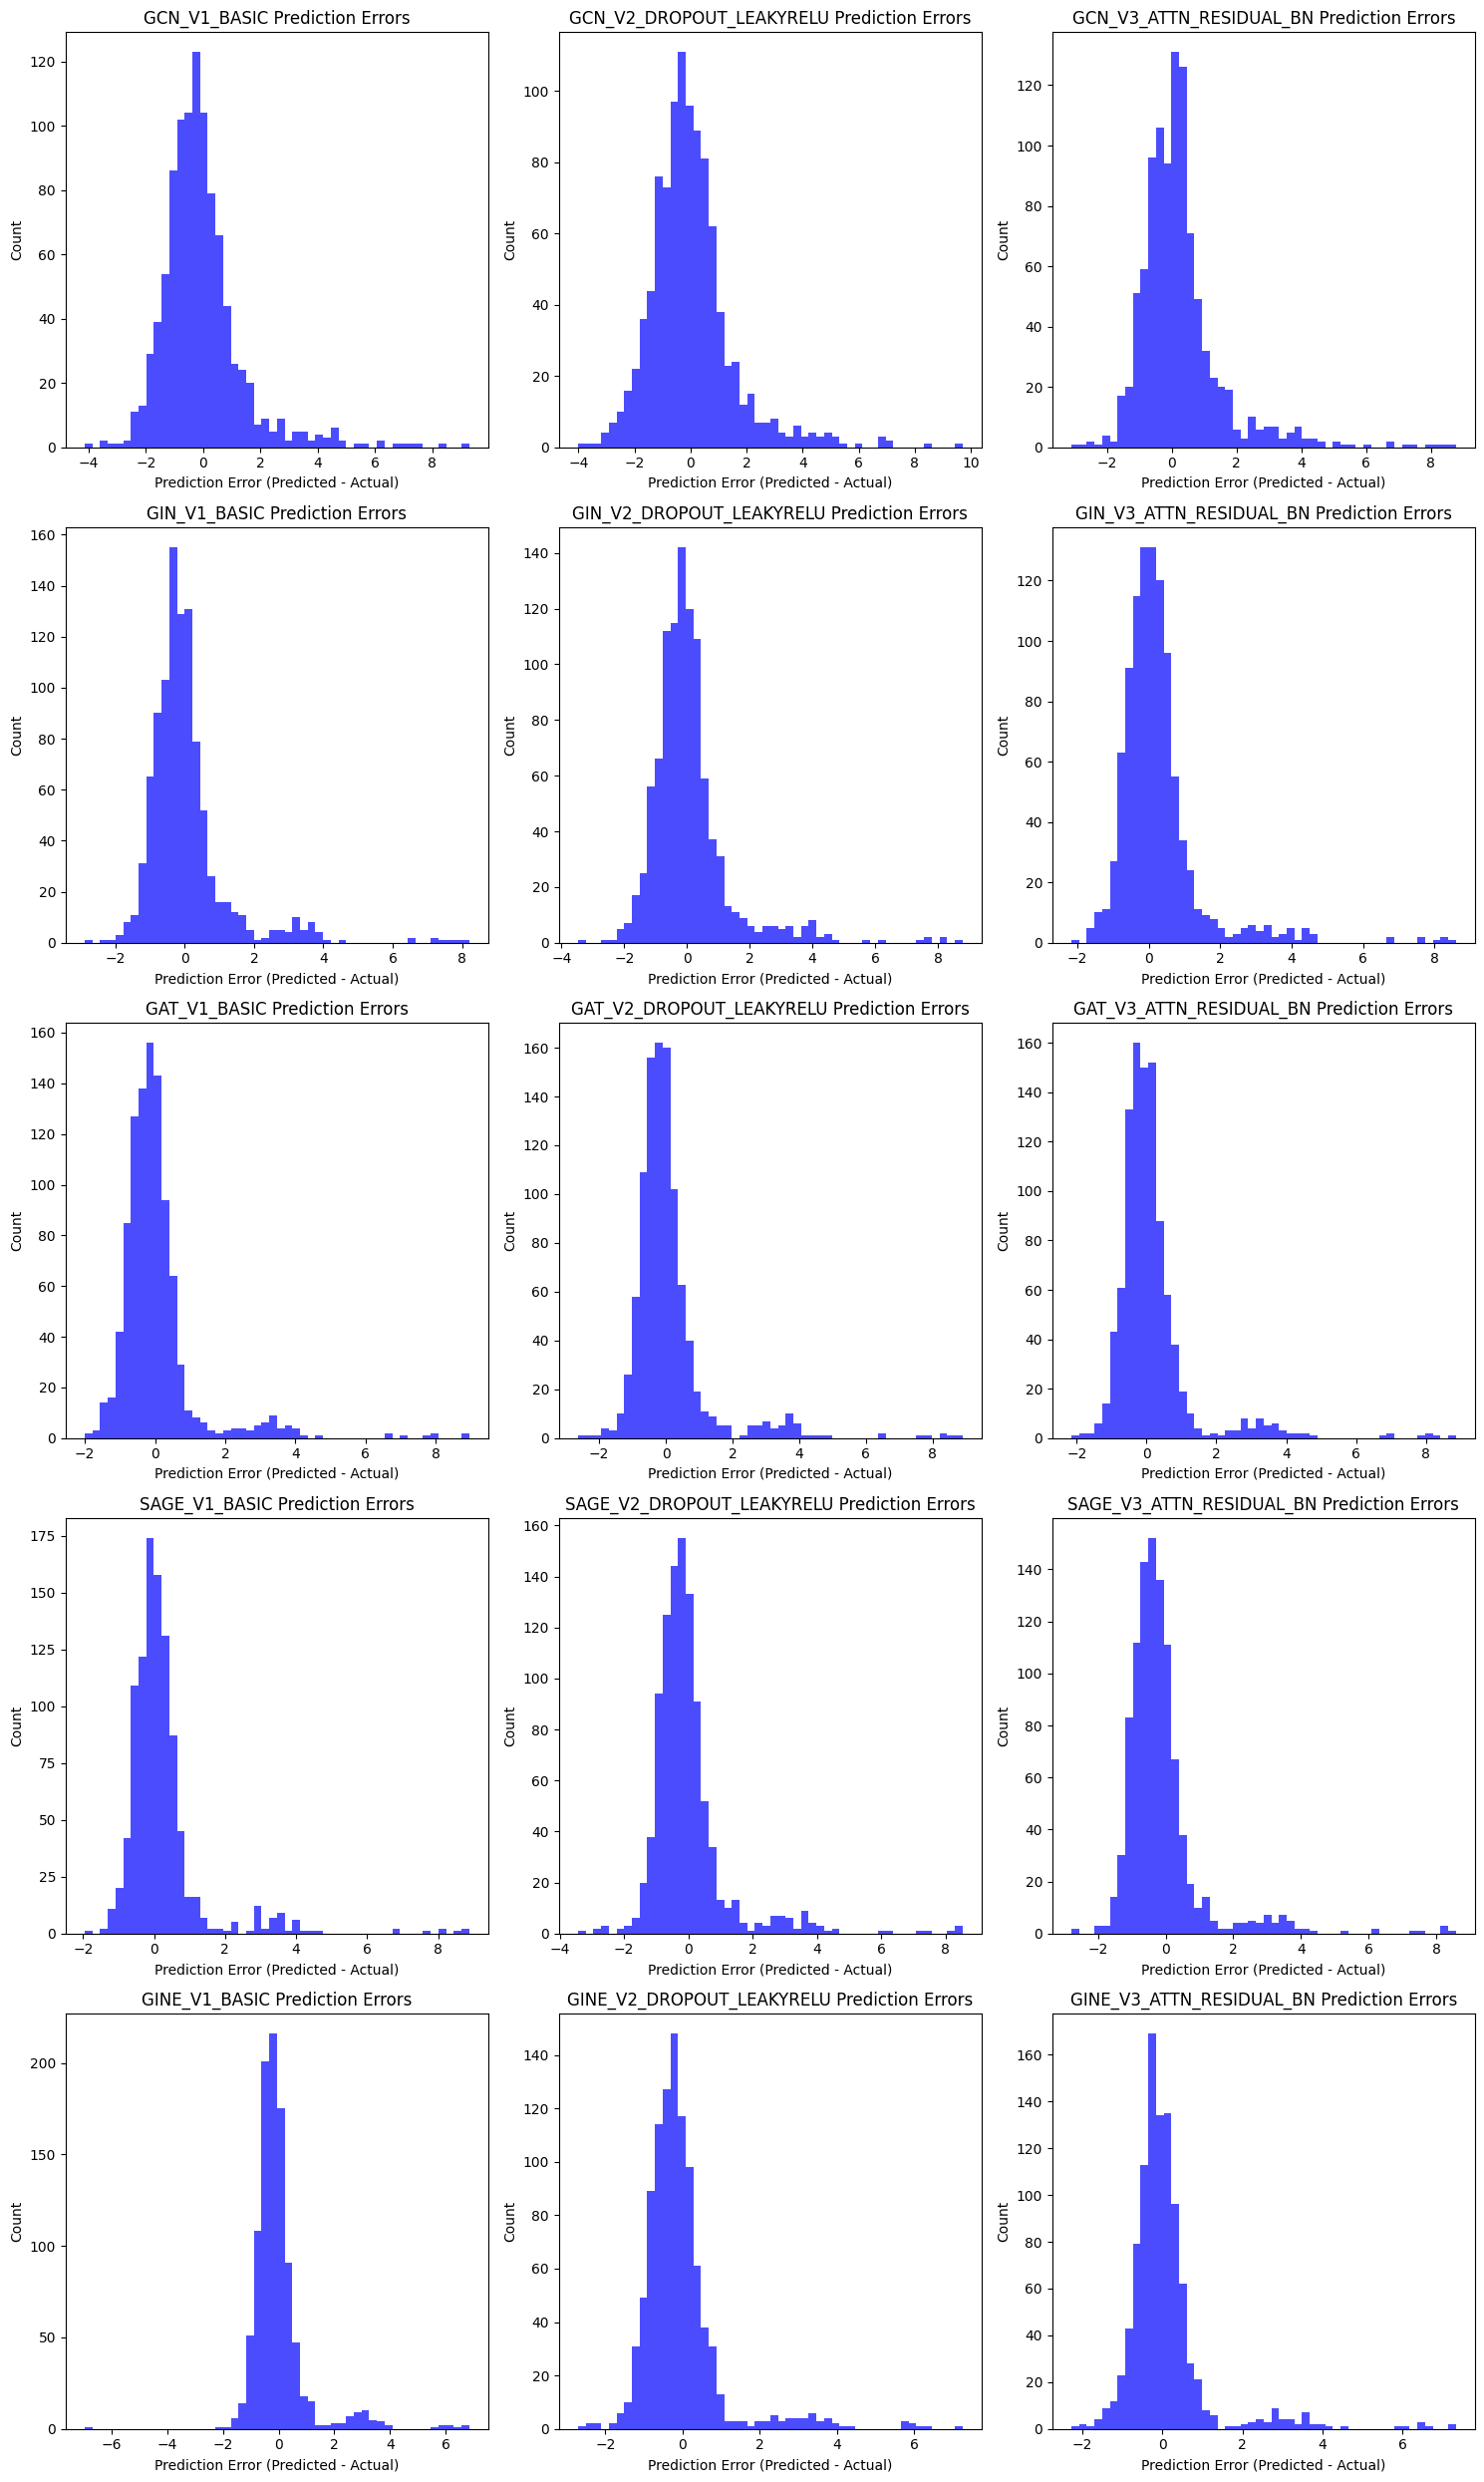

In [28]:
n_cols = 3
n_rows = int(np.ceil(len(all_results) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()  # So we can index them with a single loop

for idx, (model_name, info_dict) in enumerate(all_results.items()):
    ax = axes[idx]
    
    preds = info_dict.get('preds_np', None)
    targets = info_dict.get('targets_np', None)
    
    if preds is not None and targets is not None:
        # Calculate errors
        errors = preds - targets
        
        # Plot histogram on this subplot's axes
        ax.hist(errors, bins=50, alpha=0.7, color='blue')
        
        # Set labels, title
        ax.set_xlabel('Prediction Error (Predicted - Actual)')
        ax.set_ylabel('Count')
        ax.set_title(f'{model_name.upper()} Prediction Errors')
    else:
        # If preds/targets not found, just show a message
        ax.text(0.5, 0.5, f"No preds in {model_name}", ha='center', va='center')
        ax.set_axis_off()

# Turn off any unused subplots (if len(all_results) < n_rows * n_cols)
for extra_ax in axes[len(all_results):]:
    extra_ax.set_axis_off()

plt.tight_layout()
plt.savefig("../images/comparative_y_hist.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [10]:
all_results.keys()

dict_keys(['GCN_V1_Basic', 'GCN_V2_Dropout_LeakyReLU', 'GCN_V3_Attn_Residual_BN', 'GIN_V1_Basic', 'GIN_V2_Dropout_LeakyReLU', 'GIN_V3_Attn_Residual_BN', 'GAT_V1_Basic', 'GAT_V2_Dropout_LeakyReLU', 'GAT_V3_Attn_Residual_BN', 'SAGE_V1_Basic', 'SAGE_V2_Dropout_LeakyReLU', 'SAGE_V3_Attn_Residual_BN', 'GINE_V1_Basic', 'GINE_V2_Dropout_LeakyReLU', 'GINE_V3_Attn_Residual_BN'])

In [16]:
all_results['GCN_V1_Basic'].keys()

dict_keys(['variation', 'epoch', 'train_loss', 'val_loss', 'epoch_time', 'num_params', 'test_loss', 'test_mae', 'test_r2', 'preds_np', 'targets_np'])

In [23]:
import numpy   as np

In [ ]:
import pandas as pd
import numpy as np

# Sample keys in all_results[var_name]: 
# ['variation', 'epoch', 'train_loss', 'val_loss', 
#  'epoch_time', 'num_params', 'test_loss', 'test_mae', 'test_r2', 
#  'preds_np', 'targets_np']

data_rows = []

for var_name, info_dict in all_results.items():
    row = {
        "Variation": var_name,
        "MeanEpochTime": np.round(np.mean(info_dict["epoch_time"]), 2),
        "TestLoss": np.round(info_dict["test_loss"], 2),
        "TestMAE": np.round(info_dict["test_mae"], 2),
        "TestR2": np.round(info_dict["test_r2"], 2)
        
    }
    data_rows.append(row)

df_results = pd.DataFrame(data_rows)
df_results

,Variation,MeanEpochTime,TestLoss,TestMAE,TestR2
0,GCN_V1_Basic,0.93,1.98,0.96,0.51
1,GCN_V2_Dropout_LeakyReLU,1.13,2.23,1.04,0.45
2,GCN_V3_Attn_Residual_BN,1.35,1.79,0.83,0.56
3,GIN_V1_Basic,0.72,1.36,0.71,0.66
4,GIN_V2_Dropout_LeakyReLU,0.92,1.59,0.79,0.61
5,GIN_V3_Attn_Residual_BN,1.13,1.41,0.68,0.65
6,GAT_V1_Basic,2.28,1.31,0.65,0.68
7,GAT_V2_Dropout_LeakyReLU,1.62,1.38,0.66,0.66
8,GAT_V3_Attn_Residual_BN,1.77,1.32,0.63,0.68
9,SAGE_V1_Basic,0.98,1.28,0.59,0.68


In [11]:
all_results['GCN_V1_Basic'].keys()

dict_keys(['variation', 'epoch', 'train_loss', 'val_loss', 'epoch_time', 'num_params', 'test_loss', 'test_mae', 'test_r2', 'preds_np', 'targets_np'])

## GINE - Final

In [28]:
gine_v3_final_params = {
    'model_name': 'gine',
    'in_channels': in_channels,
    'hidden_dim': 64,
    'out_channels': 1,
    'dropout': 0.3,
    'activation': 'leakyrelu',
    'pool': 'attention',
    'residual': True,
    'batch_norm': True
}

###############################################################################
# GINE V3
###############################################################################
gine_v3_final_reloaded = get_model(**gine_v3_final_params).to(device)
gine_v3_final_reloaded.load_state_dict(torch.load(os.path.join(save_dir, "final_model.pt"), map_location=device))
gine_v3_final_reloaded.eval()

gine_v3_info_reloaded = torch.load(os.path.join(save_dir, "final_info.pt"))
print("GINE_V3 final model and info loaded!")
print("Saved final test loss:", gine_v3_info_reloaded['test_loss'])



GINE_V3 final model and info loaded!
Saved final test loss: 0.8035382665872574


/opt/anaconda3/envs/GNN/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)
/var/folders/p5/dn4spxsx2897rzdgf07vym2c0000gn/T/ipykernel_62969/2960569533.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only

In [40]:
gine_v3_info_reloaded.keys()

dict_keys(['variation', 'epoch', 'train_loss', 'val_loss', 'epoch_time', 'test_loss', 'test_mae', 'test_r2'])

In [45]:
np.average(gine_v3_info_reloaded['epoch_time'])

np.float64(31.49156037314733)

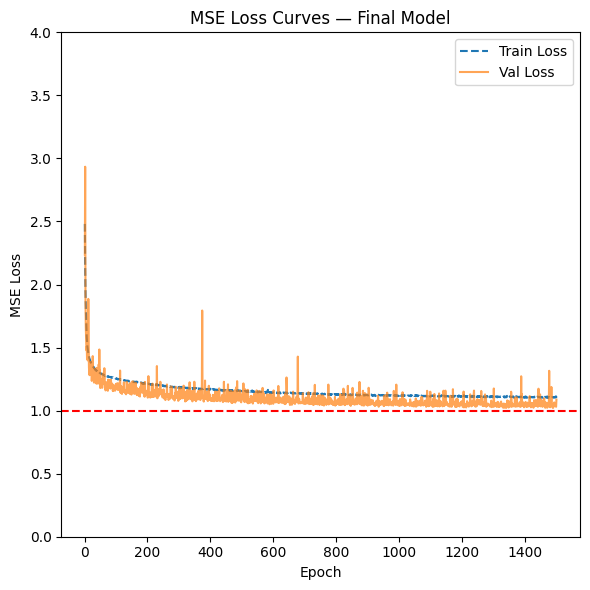

In [43]:
# Extract data from final_results
epochs = gine_v3_info_reloaded["epoch"]
train_loss = gine_v3_info_reloaded["train_loss"]
val_loss = gine_v3_info_reloaded["val_loss"]

plt.figure(figsize=(6, 6))
plt.plot(epochs, train_loss, '--', label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss', alpha=0.7)
plt.axhline(y=1, color='red', linestyle='--')   # Red dashed line at MSE=1
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MSE Loss Curves — Final Model')
plt.ylim(0, 4)   # Set a fixed y-axis range if desired
plt.legend()
plt.tight_layout()
plt.savefig("../images/final_model_loss_curves.pdf", format="pdf", bbox_inches="tight")
plt.show()


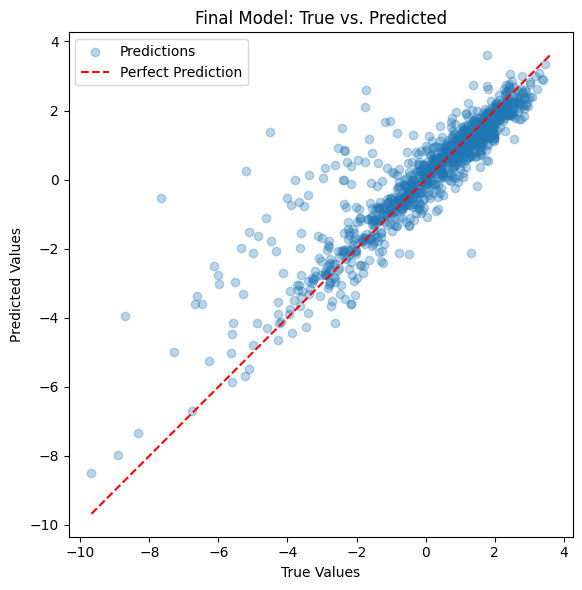

In [44]:
predictions = []
targets = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = gine_v3_final_reloaded(data.x.float(), data.edge_index, data.batch, data.edge_attr.float()).squeeze(-1)
        predictions.append(out.cpu())
        targets.append(data.y.cpu())

predictions = torch.cat(predictions, dim=0)
targets = torch.cat(targets, dim=0)

# Convert to numpy for plotting
preds = predictions.numpy()
targets = targets.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(targets, preds, alpha=0.3, label='Predictions')
# Determine min/max for diagonal plotting
min_val = min(targets.min(), preds.min())
max_val = max(targets.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Final Model: True vs. Predicted')
plt.gca().set_aspect('equal', 'box')
plt.legend()
plt.tight_layout()
plt.savefig("../images/final_model_predictions_scatter.pdf", format="pdf", bbox_inches="tight")
plt.show()


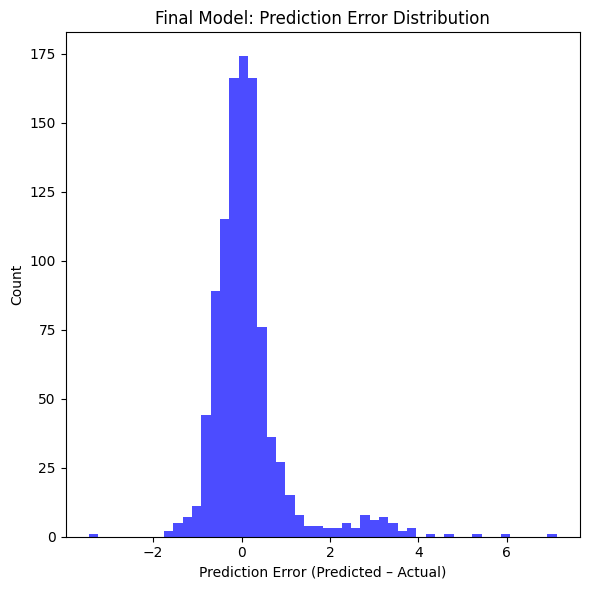

In [45]:
# Compute errors
errors = preds - targets

plt.figure(figsize=(6, 6))
plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.xlabel('Prediction Error (Predicted – Actual)')
plt.ylabel('Count')
plt.title('Final Model: Prediction Error Distribution')
plt.tight_layout()
plt.savefig("../images/final_model_error_histogram.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [49]:
gine_v3_info_reloaded['test_r2']

0.7966614961624146